In [7]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=columns)

In [9]:
# Display dataset info
print(data.head())
print(data.info())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigree  Age  Outcome  
0             0.627   50        1  
1             0.351   31        0  
2             0.672   32        1  
3             0.167   21        0  
4             2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pregnancies       768 non-null    int64  
 1   Glucose           768 non-null    int64  
 2   BloodPressure     768 non-null    int64  
 3   SkinThi

In [10]:
# Separate features and target
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [11]:
# Function to calculate metrics from confusion matrix
def calculate_metrics(cm):
    TN, FP, FN, TP = cm.ravel()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
    tss = recall + specificity - 1
    hss = (2 * (TP * TN - FP * FN)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "Precision": precision, "Recall": recall, "FPR": fpr, "FNR": fnr, "TSS": tss, "HSS": hss, "F1-Score": f1_score}

In [12]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_probs, algorithm_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{algorithm_name} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.title(f"ROC Curve for {algorithm_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

Random Forest Metrics (10-fold Average):
TP           16.000000
TN           42.300000
FP            7.700000
FN           10.800000
Precision     0.672317
Recall        0.595075
FPR           0.154146
FNR           0.404925
TSS           0.440929
HSS           0.449827
F1-Score      0.627257
dtype: float64


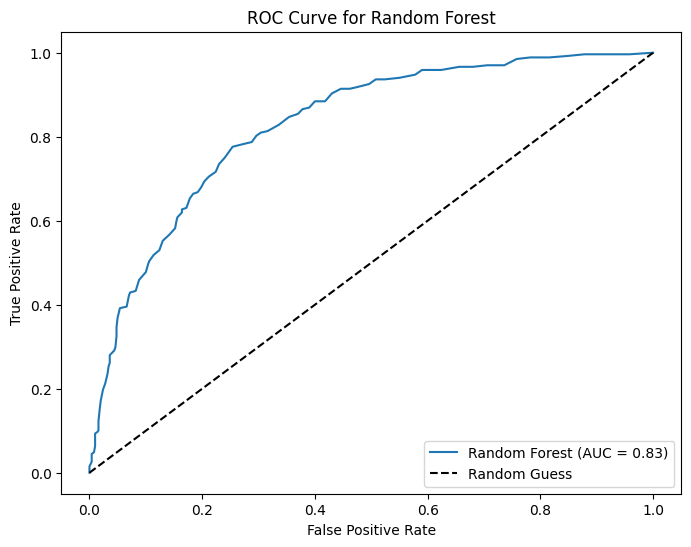

In [13]:
# Random Forest Implementation
rf_metrics = []
y_true_rf = []
y_probs_rf = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_probs = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    y_probs_rf.extend(y_probs)
    y_true_rf.extend(y_test)
    cm = confusion_matrix(y_test, y_pred)
    rf_metrics.append(calculate_metrics(cm))
rf_metrics_df = pd.DataFrame(rf_metrics)
rf_avg_metrics = rf_metrics_df.mean()
print("Random Forest Metrics (10-fold Average):")
print(rf_avg_metrics)
plot_roc_curve(y_true_rf, y_probs_rf, "Random Forest")

Decision Tree Metrics (10-fold Average):
TP           15.700000
TN           39.000000
FP           11.000000
FN           11.100000
Precision     0.586426
Recall        0.590815
FPR           0.220363
FNR           0.409185
TSS           0.370452
HSS           0.366069
F1-Score      0.585200
dtype: float64


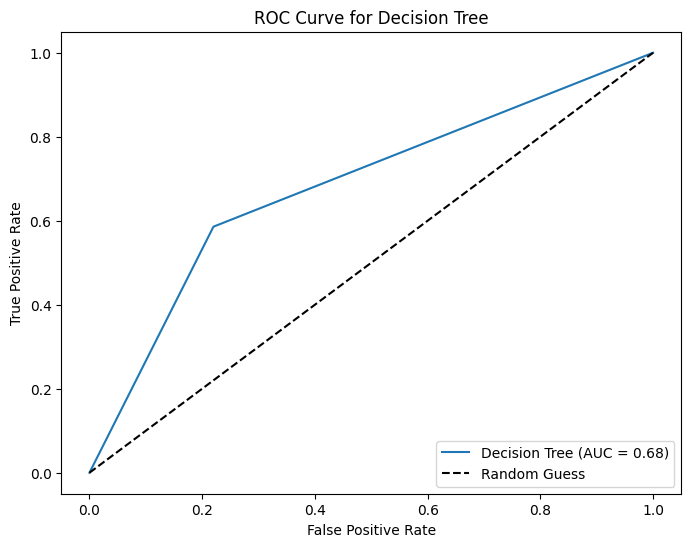

In [14]:
# Decision Tree Implementation
dt_metrics = []
y_true_dt = []
y_probs_dt = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    y_probs = dt_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    y_probs_dt.extend(y_probs)
    y_true_dt.extend(y_test)
    cm = confusion_matrix(y_test, y_pred)
    dt_metrics.append(calculate_metrics(cm))
dt_metrics_df = pd.DataFrame(dt_metrics)
dt_avg_metrics = dt_metrics_df.mean()
print("Decision Tree Metrics (10-fold Average):")
print(dt_avg_metrics)
plot_roc_curve(y_true_dt, y_probs_dt, "Decision Tree")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
LSTM Metrics (10-fold Average):
TP           14.600000
TN           41.500000
FP            8.500000
FN           12.200000
Precision     0.626704
Recall        0.543949
FPR           0.170041
FNR           0.456051
TSS           0.373907
HSS           0.382995
F1-Score      0.580132
dtype: float64


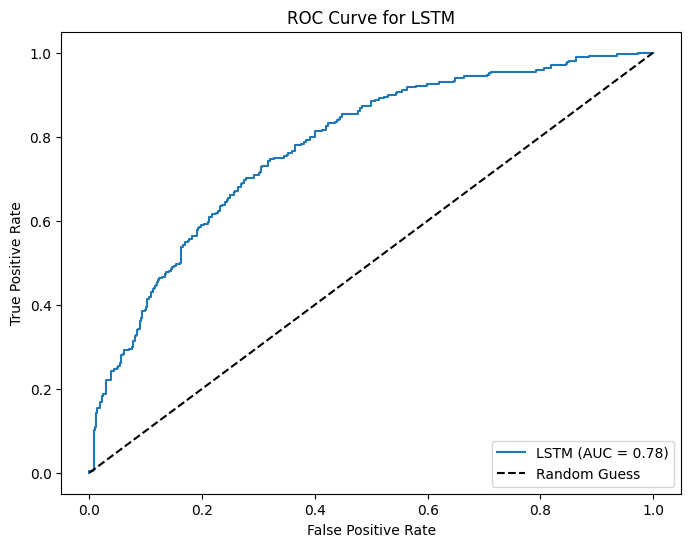

In [15]:
# LSTM Implementation
lstm_metrics = []
y_true_lstm = []
y_probs_lstm = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    lstm_model = Sequential([
        LSTM(64, input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=0)
    y_probs = lstm_model.predict(X_test_reshaped).ravel()  # Probabilities for positive class
    y_probs_lstm.extend(y_probs)
    y_true_lstm.extend(y_test)
    y_pred = (y_probs > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    lstm_metrics.append(calculate_metrics(cm))
lstm_metrics_df = pd.DataFrame(lstm_metrics)
lstm_avg_metrics = lstm_metrics_df.mean()
print("LSTM Metrics (10-fold Average):")
print(lstm_avg_metrics)
plot_roc_curve(y_true_lstm, y_probs_lstm, "LSTM")

In [16]:
# Combine Metrics into a Comparison Table
comparison_table = pd.DataFrame({
    "Algorithm": ["Random Forest", "Decision Tree", "LSTM"],
    "Precision": [rf_avg_metrics["Precision"], dt_avg_metrics["Precision"], lstm_avg_metrics["Precision"]],
    "Recall": [rf_avg_metrics["Recall"], dt_avg_metrics["Recall"], lstm_avg_metrics["Recall"]],
    "F1-Score": [rf_avg_metrics["F1-Score"], dt_avg_metrics["F1-Score"], lstm_avg_metrics["F1-Score"]],
    "FPR": [rf_avg_metrics["FPR"], dt_avg_metrics["FPR"], lstm_avg_metrics["FPR"]],
    "FNR": [rf_avg_metrics["FNR"], dt_avg_metrics["FNR"], lstm_avg_metrics["FNR"]],
    "TSS": [rf_avg_metrics["TSS"], dt_avg_metrics["TSS"], lstm_avg_metrics["TSS"]],
    "HSS": [rf_avg_metrics["HSS"], dt_avg_metrics["HSS"], lstm_avg_metrics["HSS"]],
})
print("Comparison Table:")
print(comparison_table)

Comparison Table:
       Algorithm  Precision    Recall  F1-Score       FPR       FNR       TSS  \
0  Random Forest   0.672317  0.595075  0.627257  0.154146  0.404925  0.440929   
1  Decision Tree   0.586426  0.590815  0.585200  0.220363  0.409185  0.370452   
2           LSTM   0.626704  0.543949  0.580132  0.170041  0.456051  0.373907   

        HSS  
0  0.449827  
1  0.366069  
2  0.382995  


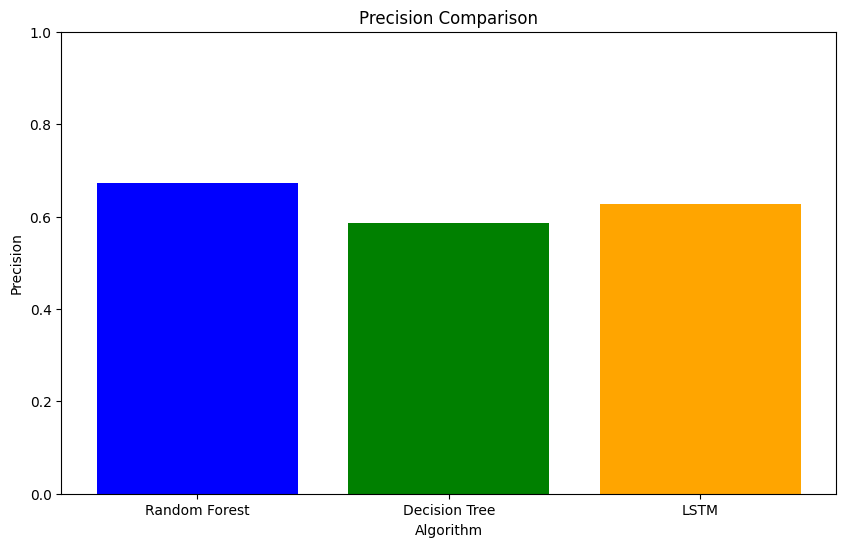

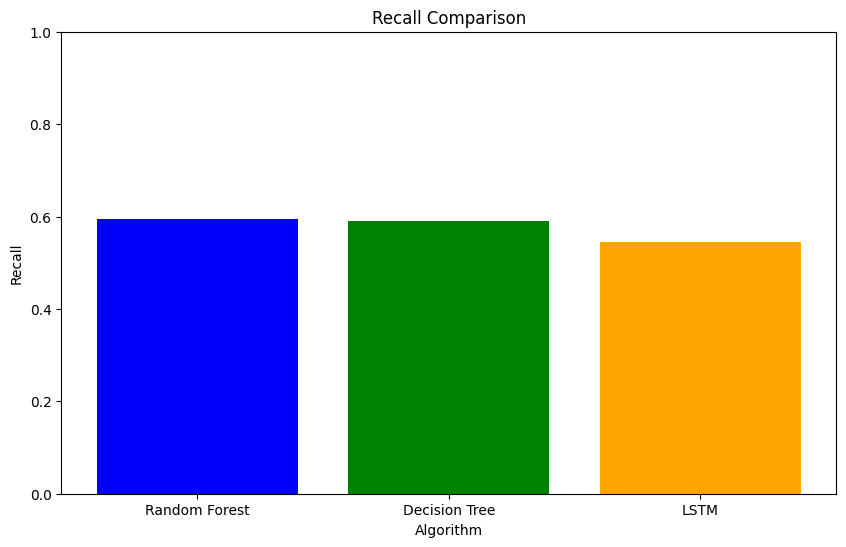

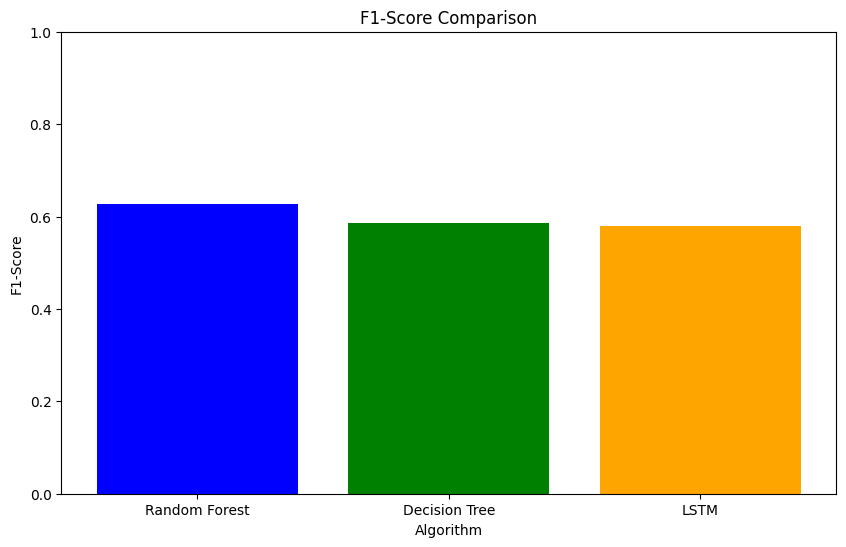

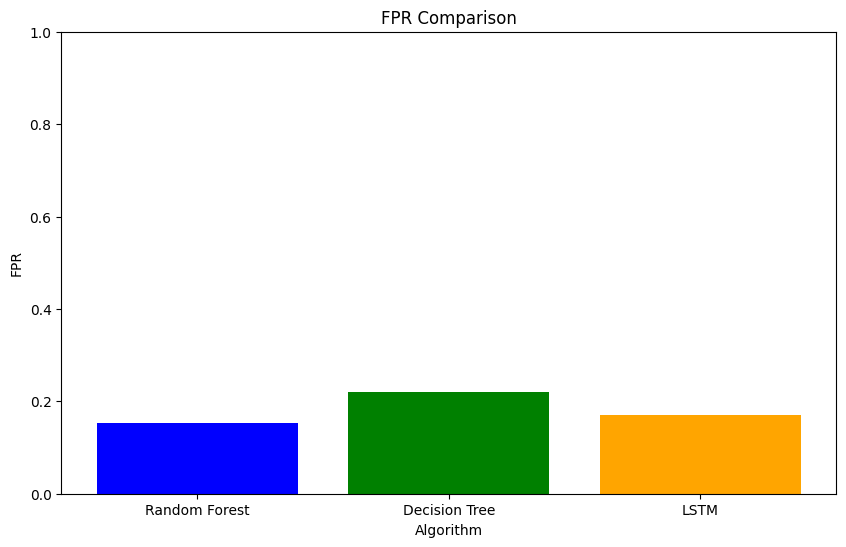

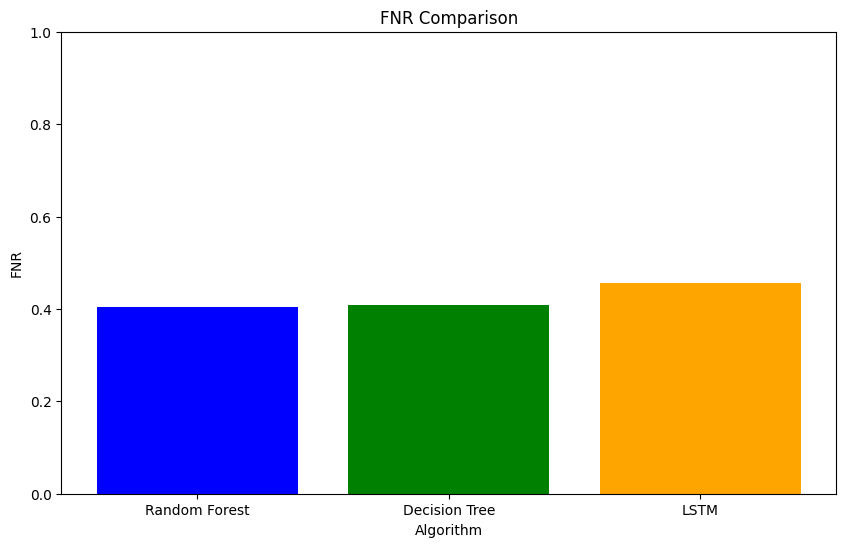

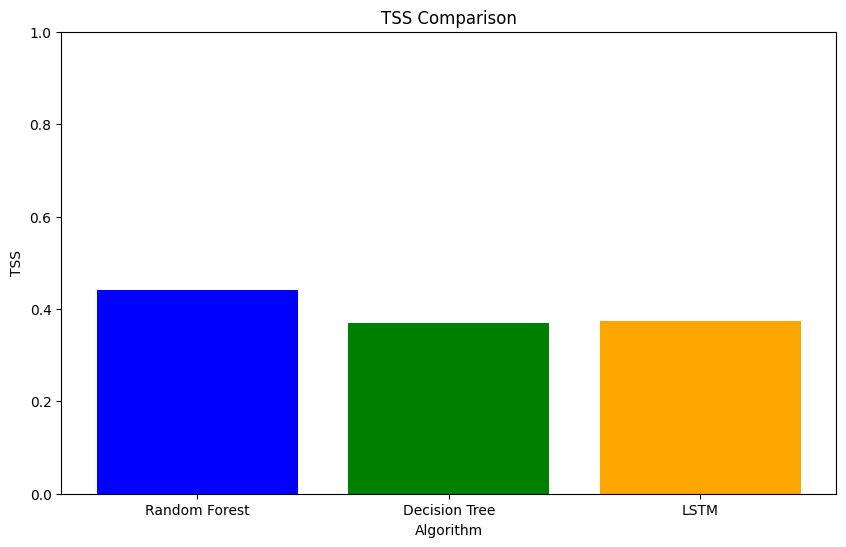

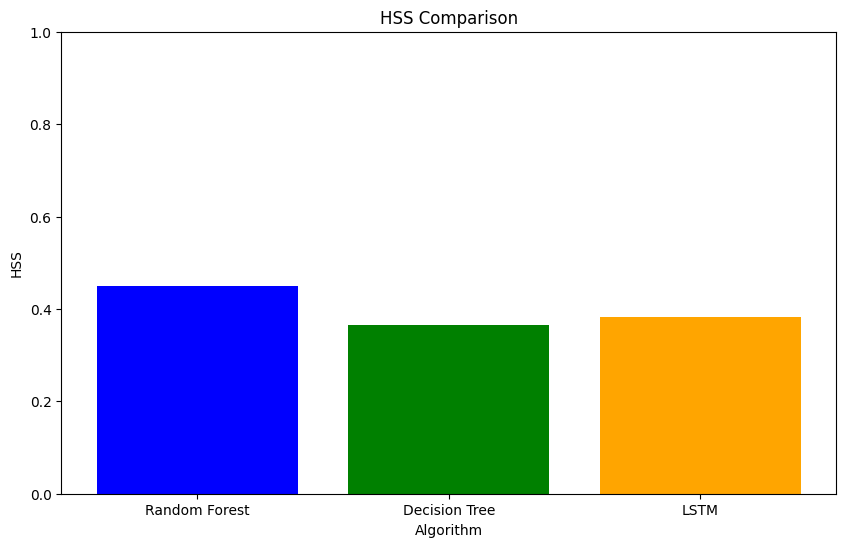

In [17]:


# Visualization Function
def plot_metric(metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_table['Algorithm'], comparison_table[metric], color=['blue', 'green', 'orange'])
    plt.title(title)
    plt.xlabel('Algorithm')
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.show()

# Visualize Metrics
for metric in ["Precision", "Recall", "F1-Score", "FPR", "FNR", "TSS", "HSS"]:
    plot_metric(metric, f"{metric} Comparison", metric)
